## PROBLEM STATEMENT

#### DOMAIN

Health Care


#### CONTEXT

Computer vision can be used in health care for identifying diseases. In Pneumonia detection we need to detect Inflammation of  the  lungs.  In  this  challenge,  you’re  required  to  build  an  algorithm  to  detect  a  visual  signal  for  pneumonia  in  medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.


#### DATA DESCRIPTION

In the dataset, some of the features are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.

Dicom original images:
- Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.
- Dataset has been attached along with this project. Please use the same for this capstone project.
- Original  link  to  the  dataset  : https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data
- Acknowledgements: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview/acknowledgements.•PROJECT OBJECTIVE: Design a DL based algorithm for detecting pneumonia

In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 33.4 MB/s eta 0:00:00


In [ ]:
# Import required libraries

# TensorFlow and Keras Imports
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Processing Libraries
import cv2

# Data Handling Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import random

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# File and Operating System Libraries
import os
import pydicom as dcm
from glob import glob

# Warnings Management
import warnings
warnings.filterwarnings('ignore')

#### PROJECT TASK: [ Score: 100 points]
#### 1. Milestone 1:[ Score: 40 points]
##### Input: Context and Dataset

#### Process
##### Step 1: Import the data. [ 3 points ]

In [ ]:
# Mount Google Drive to '/content/drive' to read dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Read and Load the dataset**

In [ ]:
train_metadata = pd.read_csv('/content/drive/MyDrive/Dataset/stage_2_train_labels.csv')

In [ ]:
print('Columns, Non-Null Counts and Datatypes in the Training set:\n')
train_metadata.info();

Columns, Non-Null Counts and Datatypes in the Training set:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [ ]:
print(f'train_metadata has {train_metadata.shape[0]} rows and {train_metadata.shape[1]} columns')

train_metadata has 30227 rows and 6 columns


In [ ]:
print('First five rows of train_metadata:\n')
print(train_metadata.head(5))

First five rows of train_metadata:

                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1


In [ ]:
print(f'train_metadata has {train_metadata.shape[0]} rows and {train_metadata.shape[1]} columns')
print(f'train_metadata has {train_metadata["patientId"].nunique()} unique patientIDs')
print(f'train_metadata has {len(train_metadata) - train_metadata["patientId"].nunique()} duplicate patientIDs')

train_metadata has 30227 rows and 6 columns
train_metadata has 26684 unique patientIDs
train_metadata has 3543 duplicate patientIDs


In [ ]:
train_class_labels = pd.read_csv('/content/drive/MyDrive/Dataset/stage_2_detailed_class_info.csv')

In [ ]:
print('Columns, Non-Null Counts and Datatypes in the train_class_labels:\n')
train_class_labels.info();

Columns, Non-Null Counts and Datatypes in the train_class_labels:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [ ]:
print(f'train_class_labels has {train_class_labels.shape[0]} rows and {train_class_labels.shape[1]} columns')

train_class_labels has 30227 rows and 2 columns


In [ ]:
print('First five rows of train_class_labels:\n')
print(train_class_labels.head(5))

First five rows of train_class_labels:

                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity


**Data Cleaning**

In [ ]:
print(f'train_class_labels has {train_class_labels["patientId"].nunique()} unique patientIDs')
print(f'train_class_labels has {len(train_class_labels) - train_class_labels["patientId"].nunique()} duplicate patientIDs')

train_class_labels has 26684 unique patientIDs
train_class_labels has 3543 duplicate patientIDs


In [ ]:
print('Number of null values in train_class_labels: {}'.format(train_class_labels['class'].isnull().sum()))

Number of null values in train_class_labels: 0


In [ ]:
print('Number of null values in bounding boxes columns: {}'.format(train_metadata[['x', 'y', 'width', 'height']].isnull().sum().to_dict()))
print('Value counts in the Target column: {}'.format(train_metadata['Target'].value_counts().to_dict()))

Number of null values in bounding boxes columns: {'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}
Value counts in the Target column: {0: 20672, 1: 9555}


- There are 20672 null values in the bounding box columns which corresponds to 0 in the Target column.
- There are 30227 rows and 26684 unique patientIDs in train_metadata and train_class_labels.

##### Step 2: Map training and testing images to its classes. [ 4 points ]

In [ ]:
# Create a dictionary mapping patient IDs to their respective class labels
image_classes = dict(zip(train_class_labels['patientId'], train_class_labels['class']))

# Display a few sample mappings for verification
print("Mapping of training and testing images to their corresponding classes:\n")
print("Sample mappings:")

# Display the first 5 mappings as an example
sample_mappings = list(image_classes.items())[:5]
for patient_id, class_label in sample_mappings:
    print(f"Patient ID: {patient_id} => Class: {class_label}")

Mapping of training and testing images to their corresponding classes:

Sample mappings:
Patient ID: 0004cfab-14fd-4e49-80ba-63a80b6bddd6 => Class: No Lung Opacity / Not Normal
Patient ID: 00313ee0-9eaa-42f4-b0ab-c148ed3241cd => Class: No Lung Opacity / Not Normal
Patient ID: 00322d4d-1c29-4943-afc9-b6754be640eb => Class: No Lung Opacity / Not Normal
Patient ID: 003d8fa0-6bf1-40ed-b54c-ac657f8495c5 => Class: Normal
Patient ID: 00436515-870c-4b36-a041-de91049b9ab4 => Class: Lung Opacity


##### Step 3: Map training and testing images to its annotations. [ 4 points ]

In [ ]:
# Create a dictionary to store the bounding box annotations for each patient ID

image_annotations = {}

# Iterate through each row in the train_labels DataFrame
for _, row in train_metadata.iterrows():
    patient_id = row['patientId']
    bbox = (row['x'], row['y'], row['width'], row['height'])

    # Add the bounding box to the list for the respective patient ID
    if patient_id not in image_annotations:
        image_annotations[patient_id] = []
    image_annotations[patient_id].append(bbox)

# Inform the user that the mapping process is complete
print("Training and testing images successfully mapped to their annotations.")

# Display sample annotations for verification
print("\nSample annotations:")
for i, (patient_id, bboxes) in enumerate(image_annotations.items()):
    print(f"Patient ID: {patient_id} => Bounding Boxes: {bboxes}")
    if i >= 7:  # Show first 8 mappings as a sample (change to 7 for 8 total)
        break


Training and testing images successfully mapped to their annotations.

Sample annotations:
Patient ID: 0004cfab-14fd-4e49-80ba-63a80b6bddd6 => Bounding Boxes: [(nan, nan, nan, nan)]
Patient ID: 00313ee0-9eaa-42f4-b0ab-c148ed3241cd => Bounding Boxes: [(nan, nan, nan, nan)]
Patient ID: 00322d4d-1c29-4943-afc9-b6754be640eb => Bounding Boxes: [(nan, nan, nan, nan)]
Patient ID: 003d8fa0-6bf1-40ed-b54c-ac657f8495c5 => Bounding Boxes: [(nan, nan, nan, nan)]
Patient ID: 00436515-870c-4b36-a041-de91049b9ab4 => Bounding Boxes: [(264.0, 152.0, 213.0, 379.0), (562.0, 152.0, 256.0, 453.0)]
Patient ID: 00569f44-917d-4c86-a842-81832af98c30 => Bounding Boxes: [(nan, nan, nan, nan)]
Patient ID: 006cec2e-6ce2-4549-bffa-eadfcd1e9970 => Bounding Boxes: [(nan, nan, nan, nan)]
Patient ID: 00704310-78a8-4b38-8475-49f4573b2dbb => Bounding Boxes: [(323.0, 577.0, 160.0, 104.0), (695.0, 575.0, 162.0, 137.0)]


##### Step 4: Preprocessing and Visualisation of different classes [4 Points]

In [ ]:
# Count the number of cases with and without pneumonia
pneumonia_count = train_metadata[train_metadata.Target == 1].shape[0]
no_pneumonia_count = train_metadata[train_metadata.Target == 0].shape[0]

# Calculate percentages
pneumonia_percentage = round((pneumonia_count / train_metadata.shape[0]) * 100, 0)
no_pneumonia_percentage = round((no_pneumonia_count / train_metadata.shape[0]) * 100, 0)

# Print the counts and percentages
print(f'No of entries which has Pneumonia: {pneumonia_count} ~ {pneumonia_percentage}%')
print(f'No of entries which don\'t have Pneumonia: {no_pneumonia_count} ~ {no_pneumonia_percentage}%')

No of entries which has Pneumonia: 9555 ~ 32.0%
No of entries which don't have Pneumonia: 20672 ~ 68.0%


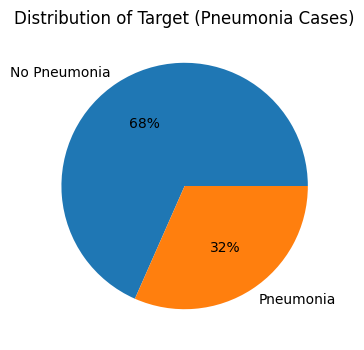

In [ ]:
# Plot a pie chart for visualization
_ = train_metadata['Target'].value_counts().plot(
    kind='pie',
    autopct='%.0f%%',
    labels=['No Pneumonia', 'Pneumonia'],
    figsize=(4, 4)
)
plt.title("Distribution of Target (Pneumonia Cases)")
plt.ylabel("")
plt.show()

The pie chart above clearly shows that out of the 30,227 entries in the dataset, 20,672 (68%) do not have pneumonia, while 9,555 (32%) do.

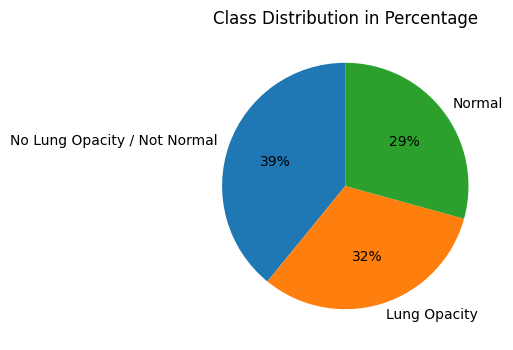

In [ ]:
# Calculate class counts and percentages
class_counts = train_class_labels['class'].value_counts()
class_percentages = (class_counts / class_counts.sum()) * 100

# Plot the pie chart
fig, ax = plt.subplots(figsize=(4, 4))
ax.pie(class_percentages, labels=class_counts.index, autopct='%.0f%%', startangle=90)

# Set title
ax.set_title('Class Distribution in Percentage')

plt.show()

In [ ]:
#Check whether each patientID has only one type of class or not
train_class_labels.groupby(['patientId'])['class'].nunique().max()

1

Each patientID has only one type of class

In [ ]:
# Calculate the number of bounding boxes per unique patient ID
bboxes = train_metadata.groupby('patientId').size().reset_index(name='number_of_boxes')

# Merge the bounding box count with the original train metadata
train_labels = train_metadata.merge(bboxes, on='patientId', how='left')

# Display the number of patient IDs associated with each bounding box count
bboxes_summary = (bboxes.groupby('number_of_boxes')
                  .size()
                  .reset_index(name='count')  # Rename the count column to 'count'
                  .sort_values(by='number_of_boxes'))

# Reorder columns to display 'count' first, then 'number_of_boxes'
bboxes_summary = bboxes_summary[['count', 'number_of_boxes']]

bboxes_summary

count  number_of_boxes
0  23286                1
1   3266                2
2    119                3
3     13                4

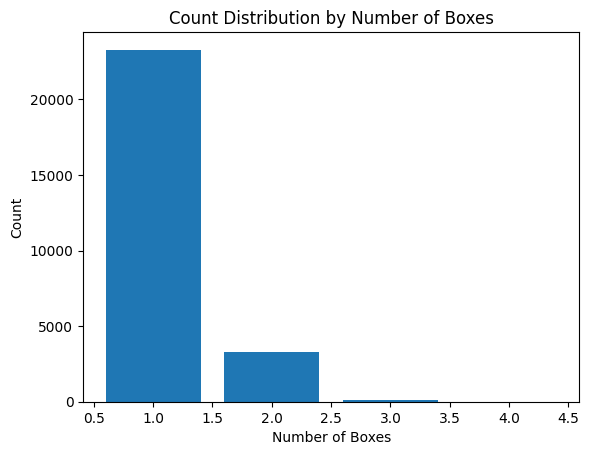

In [ ]:
plt.bar(bboxes_summary['number_of_boxes'], bboxes_summary['count'])
plt.xlabel("Number of Boxes")
plt.ylabel("Count")
_ = plt.title("Count Distribution by Number of Boxes")

In [ ]:
# Iterate through the bboxes_summary DataFrame and print each row in a human-readable format
print("\nNumber of bounding boxes per patientID count in the dataset:")

for _, row in bboxes_summary.iterrows():
    print(f"Patient IDs count: {row['count']} | Bounding boxes: {row['number_of_boxes']}")


Number of bounding boxes per patientID count in the dataset:
Patient IDs count: 23286 | Bounding boxes: 1
Patient IDs count: 3266 | Bounding boxes: 2
Patient IDs count: 119 | Bounding boxes: 3
Patient IDs count: 13 | Bounding boxes: 4


**Merge dataset**

In [ ]:
train_dataset = pd.concat([train_metadata, train_class_labels['class']], axis = 1)
print("Merged train_dataset:")
train_dataset.head()

Merged train_dataset:


patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

In [ ]:
print(f'train_dataset has {train_dataset.shape[0]} rows and {train_dataset.shape[1]} columns')

train_dataset has 30227 rows and 7 columns


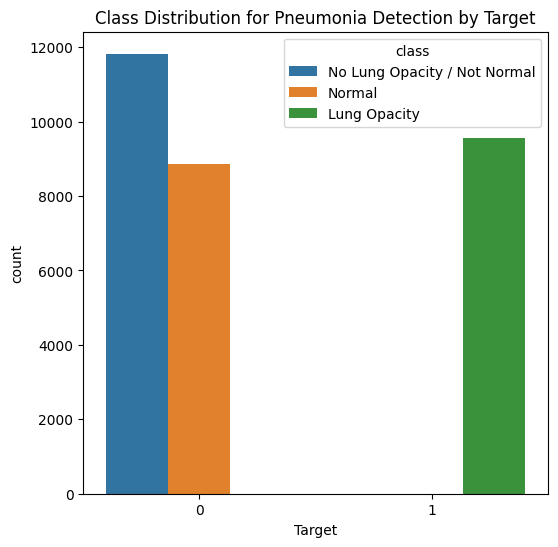

In [ ]:
# Create a figure and axis object for the plot
fig, ax = plt.subplots(nrows=1, figsize=(6, 6))

# Group the data by 'Target' and 'class' and count the occurrences
class_counts = train_dataset.groupby(['Target', 'class']).size().reset_index(name='count')

# Create the bar plot with seaborn
sns.barplot(ax=ax, x='Target', y='count', hue='class', data=class_counts)

# Set the title for the plot
plt.title('Class Distribution for Pneumonia Detection by Target')

# Show the plot
plt.show()

To effectively manage and analyze this data, we can break it down into the following components:

* **Patient IDs** Some of which are duplicated due to multiple bounding boxes per patient

* **Bounding box coordinates:** Defined by x, y, width, and height

* **Target:**
Target = 1 indicates the presence of pneumonia.
Target = 0 indicates no definitive evidence of pneumonia.

* **Class Labels:** The dataset also includes a class label with three possible categories:
  * Lung Opacity: Suggests the presence of pneumonia (corresponding to Target = 1).
  * Normal or No Lung Opacity / Not Normal: Corresponds to Target = 0 (indicating no pneumonia).

* **Bounding Box Distribution:** A large proportion of patient IDs (23,286 or 87%) have only one bounding box.
A small number of patients (13 individuals) have up to four bounding boxes, potentially indicating multiple findings within a single image.

**Reading the DICOM file**

In [ ]:
sample_patientId = train_labels['patientId'][0]
dcm_file = '/content/drive/MyDrive/Dataset/stage_2_train_images/'+'{}.dcm'.format(sample_patientId)
dcm_data = dcm.dcmread(dcm_file)

print('Metadata of the image consists of \n', dcm_data)

Metadata of the image consists of 
 Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 202
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002,0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002,0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002,0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008,0020) Study Date                          DA: '19010101'
(000

#### Observations:
The DICOM metadata contains both patient information and technical details about the image:

* **Patient Information:** This includes identifiers (such as name and ID), demographic details (like age and sex), and the body part examined (in this case, "CHEST").

* **Image Technical Details:** The metadata also provides information about the image itself, such as its resolution (1024x1024 pixels), pixel spacing, and compression format (e.g., JPEG).

Additionally, the DICOM standard includes information about the imaging device, study, and series, all of which play a crucial role in organizing and managing medical imaging data.

Following analysis derived from the image data

* **Age Distribution:** Investigate the age distribution of patients with evidence of lung opacity versus those without definitive evidence. This analysis will help identify any age-related trends or patterns in patients with and without signs of lung opacity.

* **Gender Distribution:** Analyze the distribution of male and female patients within the groups with and without lung opacity evidence. This could uncover any gender-based differences in the prevalence of lung opacity.

* **View Positions:** Examine the different imaging view positions (e.g., PA) in the dataset to understand how the images were captured. This could provide insights into imaging protocols or preferences used during the chest examinations.

* **Imaging Modality:** Explore the imaging modalities used (e.g., CR, CT) to gain a better understanding of the types of equipment or methods employed in capturing these chest X-ray images.

In [ ]:
print('Number of images in training images folders are: {}.'.format(len(os.listdir('/content/drive/MyDrive/Dataset/stage_2_train_images'))))

Number of images in training images folders are: 26684.


In [ ]:
# Define path to the training images
training_image_path = '/content/drive/MyDrive/Dataset/stage_2_train_images'

# Create a DataFrame with paths to each .dcm file in the specified directory
images = pd.DataFrame({'path': glob(os.path.join(training_image_path, '*.dcm'))})

# Extract patientId by removing the file extension and directory path
images['patientId'] = images['path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

# Display the column names in the DataFrame
print(f"Columns in the training images DataFrame: {list(images.columns)}")

Columns in the training images DataFrame: ['path', 'patientId']


In [ ]:
# Merging the images dataframe with merge_data dataframe
train_dataset = train_dataset.merge(images, on = 'patientId', how = 'left')
print('After merging the two dataframe, the merge_data has {} rows and {} columns.'.format(train_dataset.shape[0], train_dataset.shape[1]))

After merging the two dataframe, the merge_data has 30227 rows and 8 columns.


In [ ]:
train_dataset.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  \
0  No Lung Opacity / Not Normal   
1  No Lung Opacity / Not Normal   
2  No Lung Opacity / Not Normal   
3                        Normal   
4                  Lung Opacity   

                                                path  
0  /content/drive/MyDrive/Dataset/stage_2_train_i...  
1  /content/drive/MyDrive/Dataset/stage_2_train_i...  
2  /content/drive/MyDrive/Dataset/stage_2_train_i...  
3  /content/drive/MyDrive/Dataset/stage_2_train_i...  
4  /content/drive/MyDrive/Dataset/stage_2_train_i...

In [ ]:
# List of columns to add to the DataFrame
columns_to_add = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined',
                  'ViewPosition']

def parse_dicom_data(data_df, data_path):
    # Initialize empty columns for new features
    for col in columns_to_add:
        data_df[col] = None

    # List all image filenames in the specified directory
    image_names = os.listdir(data_path)

    # Iterate over the image files with a progress bar
    for img_name in tqdm(image_names, desc="Processing DICOM files"):
        image_path = os.path.join(data_path, img_name)
        try:
            # Attempt to read the DICOM file
            dicom_data = dcm.dcmread(image_path, force=True)

            # Ensure the DICOM file contains a 'PatientID'
            if 'PatientID' in dicom_data:
                # Find the corresponding row in the DataFrame based on PatientID
                patient_idx = data_df['patientId'] == dicom_data.PatientID

                # Extract and assign metadata from the DICOM file to the DataFrame
                data_df.loc[patient_idx, 'Modality'] = getattr(dicom_data, 'Modality', None)
                data_df.loc[patient_idx, 'PatientAge'] = pd.to_numeric(getattr(dicom_data, 'PatientAge', None), errors='coerce')
                data_df.loc[patient_idx, 'PatientSex'] = getattr(dicom_data, 'PatientSex', None)
                data_df.loc[patient_idx, 'BodyPartExamined'] = getattr(dicom_data, 'BodyPartExamined', None)
                data_df.loc[patient_idx, 'ViewPosition'] = getattr(dicom_data, 'ViewPosition', None)
                #data_df.loc[patient_idx, 'ConversionType'] = getattr(dicom_data, 'ConversionType', None)
                #data_df.loc[patient_idx, 'Rows'] = getattr(dicom_data, 'Rows', None)
                #data_df.loc[patient_idx, 'Columns'] = getattr(dicom_data, 'Columns', None)
                #data_df.loc[patient_idx, 'PixelSpacing'] = str(getattr(dicom_data, 'PixelSpacing', [None])[0])

        except dcm.errors.InvalidDicomError:
            print(f"Skipping non-DICOM file: {img_name}")
        except Exception as e:
            print(f"Error processing file {img_name}: {e}")

# Example usage:
parse_dicom_data(train_dataset, '/content/drive/MyDrive/Dataset/stage_2_train_images/')


Processing DICOM files: 100%|██████████| 26684/26684 [2:49:12<00:00,  2.63it/s]


In [ ]:
print('After parsing the information from the dicom images, train_dataset has {} rows and {} columns:\n'.format(train_dataset.shape[0],train_dataset.shape[1]))

After parsing the information from the dicom images, train_dataset has 30227 rows and 13 columns:



In [ ]:
train_dataset.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  \
0  No Lung Opacity / Not Normal   
1  No Lung Opacity / Not Normal   
2  No Lung Opacity / Not Normal   
3                        Normal   
4                  Lung Opacity   

                                                path Modality PatientAge  \
0  /content/drive/MyDrive/Dataset/stage_2_train_i...       CR         51   
1  /content/drive/MyDrive/Dataset/stage_2_train_i...       CR         48   
2  /content/drive/MyDrive/Dataset/stage_2_train_i...       CR         19   
3  /content/drive/MyDrive/Dataset/stage_2_train_i...       CR         28   
4  /content/drive/MyDrive/Dataset/stage_2_train_i...       CR         32   

  PatientSex BodyPartExamined ViewPosition  
0          F            CHEST           PA  
1          F            CHEST           PA  
2          M            CHEST           AP  
3          M            CHEST           PA  
4          F            CHEST           AP

**Import dataset to pickle**

In [ ]:
train_dataset.to_pickle('train_dataset.pkl')

In [ ]:
train_dataset = pd.read_pickle('train_dataset.pkl')
print(f'train_dataset consists of {train_dataset.shape[0]} rows and {train_dataset.shape[1]} columns: \n')
train_dataset.head()

train_dataset consists of 30227 rows and 13 columns: 



patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  \
0  No Lung Opacity / Not Normal   
1  No Lung Opacity / Not Normal   
2  No Lung Opacity / Not Normal   
3                        Normal   
4                  Lung Opacity   

                                                path Modality PatientAge  \
0  /content/drive/MyDrive/Dataset/stage_2_train_i...       CR         51   
1  /content/drive/MyDrive/Dataset/stage_2_train_i...       CR         48   
2  /content/drive/MyDrive/Dataset/stage_2_train_i...       CR         19   
3  /content/drive/MyDrive/Dataset/stage_2_train_i...       CR         28   
4  /content/drive/MyDrive/Dataset/stage_2_train_i...       CR         32   

  PatientSex BodyPartExamined ViewPosition  
0          F            CHEST           PA  
1          F            CHEST           PA  
2          M            CHEST           AP  
3          M            CHEST           PA  
4          F            CHEST           AP

### Perform Exploratory Data Analysis (EDA)

In [ ]:
print('All images are obtained with one modality, which is: {} \n'.format(train_dataset['Modality'].unique()[0]))

All images are obtained with one modality, which is: CR 



In [ ]:
print('All images are examined on one body part, which is {} area.\n'.format(train_dataset['BodyPartExamined'].unique()[0]))

All images are examined on one body part, which is CHEST area.



In [ ]:
def get_feature_distribution(data, feature):
    """
    Prints the distribution of a given feature in the dataset,
    including the count and percentage of each unique value.

    Parameters:
    data (DataFrame): The dataset containing the feature.
    feature (str): The name of the feature (column) to analyze.
    """

    print(f"Distribution for Feature: '{feature}'")

    # Calculate total count, value counts, and percentage distribution
    total_count = len(data)
    value_counts = data[feature].value_counts()
    percentages = data[feature].value_counts(normalize=True) * 100

    # Print the distribution for each unique value in the feature
    for value, count in value_counts.items():
        percentage = percentages[value]
        print(f"{value:<30}: {count} occurrences ({percentage:.2f}%) of total data")

# Example usage:
get_feature_distribution(train_dataset, 'ViewPosition')


Distribution for Feature: 'ViewPosition'
AP                            : 15297 occurrences (50.61%) of total data
PA                            : 14930 occurrences (49.39%) of total data


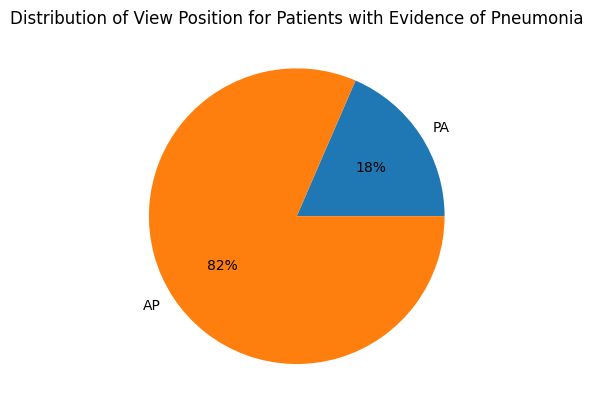

In [ ]:
# Plot the distribution of 'ViewPosition' for patients with evidence of pneumonia (Target == 1)
_ = train_dataset.loc[train_dataset['Target'] == 1, 'ViewPosition'] \
    .value_counts() \
    .sort_index(ascending=False) \
    .plot(kind='pie', autopct='%.0f%%', legend=False, title='Distribution of View Position for Patients with Evidence of Pneumonia') \
    .set_ylabel('')

#### View Positions in the Training Dataset:

* The training dataset includes two main View Positions used for chest X-rays: AP (Anterior/Posterior) and PA (Posterior/Anterior).

* Both are primarily employed to capture the front view of the chest, with a lateral view often taken as a complementary angle.

**Posterior/Anterior (PA):**

* In a PA X-ray, the X-ray beam passes from the posterior (back) to the
anterior (front) of the chest.
* The patient is typically asked to stand with their chest against the film or detector.
* As a result of this positioning, the heart appears on the right side of the image when viewed.
* PA images are generally of higher quality and offer a more accurate representation of heart size, making them the preferred view for chest X-rays.

**Anterior/Posterior (AP):**
* AP X-rays are used when a PA image cannot be obtained, often due to the patient's inability to stand (e.g., in cases of severe illness).
* In this view, the X-ray beam passes from the anterior (front) to the posterior (back) of the chest.
* AP images may result in an exaggerated appearance of the heart size, as the patient is often lying down or seated during the procedure, altering the geometry of the chest in relation to the X-ray beam.

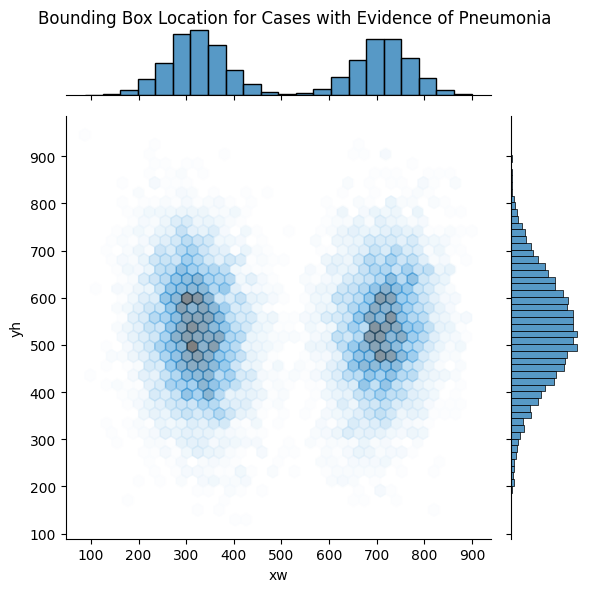

In [ ]:
# Plot the x and y centers of bounding boxes for cases with evidence of pneumonia
bboxes = train_dataset[train_dataset['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2  # Calculate the x-center of the bounding box
bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2  # Calculate the y-center of the bounding box

# Create a hexbin plot for the bounding box centers
g = sns.jointplot(x='xw', y='yh', data=bboxes, kind='hex', alpha=0.5)

# Add title to the plot
plt.suptitle('Bounding Box Location for Cases with Evidence of Pneumonia')

# Adjust the layout to fit the title
plt.tight_layout()
plt.subplots_adjust(top=0.95)

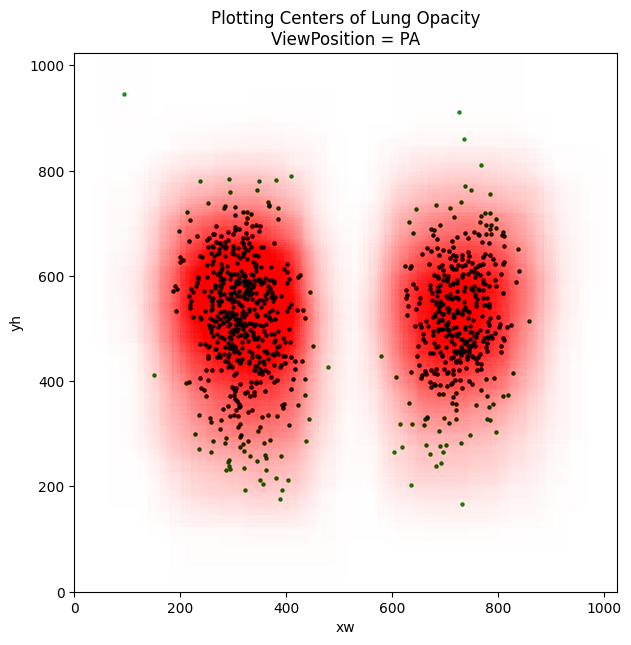

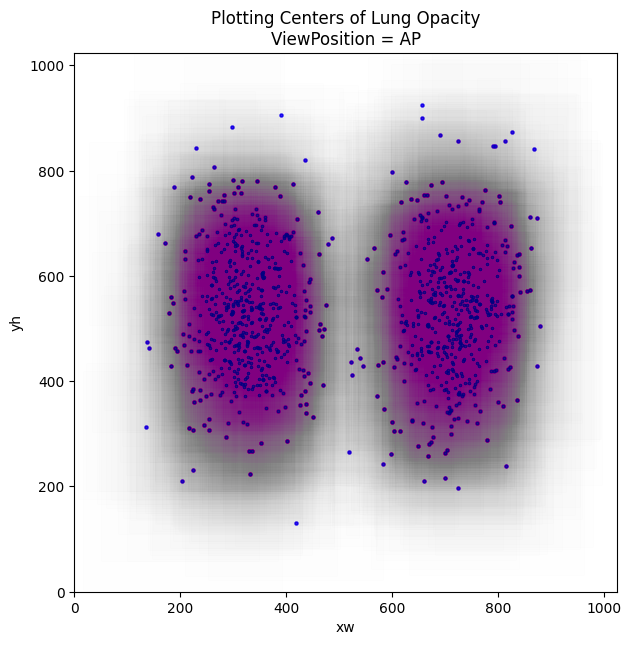

In [ ]:
def plot_bboxes_scatter(data, color_point, color_window, title_text):
    """
    Plots the centers of bounding boxes along with their respective windows (bounding boxes).

    Parameters:
    - data (DataFrame): The dataset containing bounding box coordinates and view positions.
    - color_point (str): The color for plotting the bounding box centers (scatter points).
    - color_window (str): The color for the bounding box windows.
    - title_text (str): Additional text to display in the plot title.
    """
    # Create the figure and axis for the plot
    fig, ax = plt.subplots(figsize=(7, 7))

    # Set the plot title
    ax.set_title(f'Plotting Centers of Lung Opacity\n{title_text}')

    # Plot the scatter points representing bounding box centers
    data.plot.scatter(x='xw', y='yh', ax=ax, alpha=0.8, marker='.', color=color_point, xlim=(0, 1024), ylim=(0, 1024))

    # Add the bounding box windows (rectangles) to the plot
    for _, sample in data.iterrows():
        ax.add_patch(Rectangle(
            xy=(sample['x'], sample['y']),
            width=sample['width'],
            height=sample['height'],
            alpha=0.0035,  # Adjust transparency of bounding boxes
            color=color_window
        ))

# Sample data for PA and AP view positions (subsetting 1000 samples)
data_PA = bboxes[bboxes['ViewPosition'] == 'PA'].sample(1000)
data_AP = bboxes[bboxes['ViewPosition'] == 'AP'].sample(1000)

# Plot the bounding boxes for PA and AP view positions with appropriate colors
plot_bboxes_scatter(data_PA, 'green', 'red', 'ViewPosition = PA')
plot_bboxes_scatter(data_AP, 'blue', 'purple', 'ViewPosition = AP')

#### Observations: BodyPartExamined & ViewPosition
**BodyPartExamined:** The "BodyPartExamined" attribute is consistent across all cases in the training dataset, with the value being "CHEST" as expected.

**Modality:** The dataset contains a single modality type, CR (Computer Radiography), indicating that all images were taken using this technique.

**ViewPosition:** In the overall dataset, the ViewPosition is nearly evenly distributed across different types. However, when focusing on cases where Target = 1 (i.e., pneumonia cases), the majority of the images are captured with the AP (Anterior/Posterior) view.

Distribution of Target Variable by Gender:
class       Lung Opacity  No Lung Opacity / Not Normal  Normal
PatientSex                                                    
F                   3995                          5111    3905
M                   5560                          6710    4946


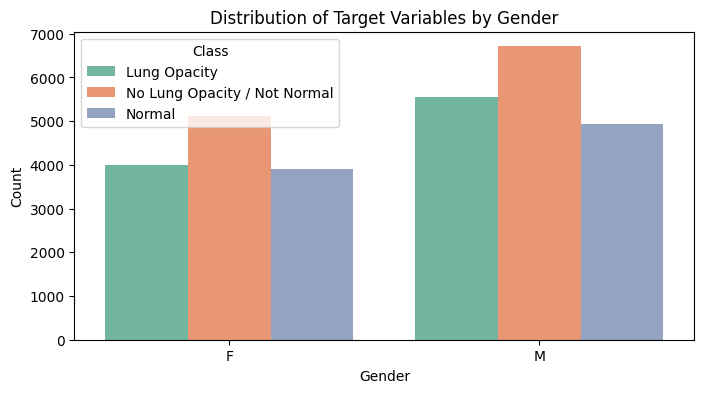

In [ ]:
# Distribution of Target Variables by Gender

# Count the distribution of 'Target' for each gender and class
target_distribution = train_dataset.groupby(['PatientSex', 'class']).size().reset_index(name='Count')

# Pivot the data for easier plotting
pivot_gender = target_distribution.pivot(index='PatientSex', columns='class', values='Count')

# Display the distribution of the Target variable by gender
print("Distribution of Target Variable by Gender:")
print(pivot_gender)

# Visualization: Stacked bar plot
plt.figure(figsize=(8, 4))
sns.barplot(
    data=target_distribution,
    x='PatientSex',
    y='Count',
    hue='class',
    palette='Set2'
)

# Add labels, title, and legend to the plot
plt.title('Distribution of Target Variables by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Class', loc='upper left')
plt.show()

Distribution of Age vs Lung Opacity by Age Group:
class     Lung Opacity  No Lung Opacity / Not Normal  Normal
AgeGroup                                                    
0-18               678                           490     530
19-30             1451                          1395    1363
31-50             3266                          3631    3325
51-70             3539                          5361    3276
71-100+            621                           942     354


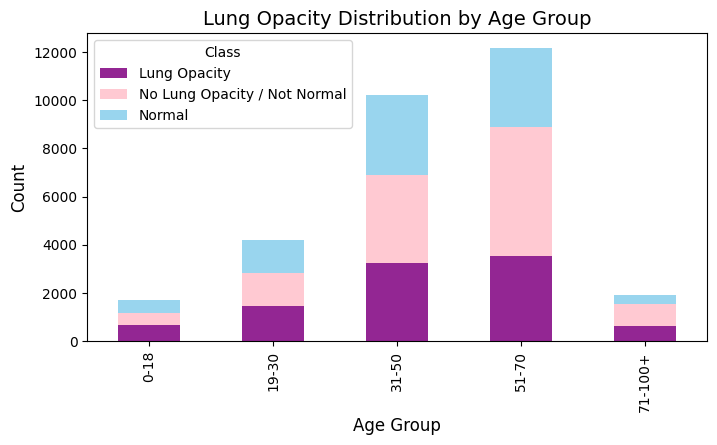

In [ ]:
# Distribution of Age vs Lung Opacity

# Define age groups using bin ranges
bins = [0, 18, 30, 50, 70, 100]  # Age group boundaries
labels = ['0-18', '19-30', '31-50', '51-70', '71-100+']  # Age group labels

# Create a new column 'AgeGroup' in the dataset by binning the 'PatientAge'
train_dataset['AgeGroup'] = pd.cut(train_dataset['PatientAge'], bins=bins, labels=labels)

# Calculate the distribution of the 'Target' variable for each AgeGroup and class
age_group_distribution = train_dataset.groupby(['AgeGroup', 'class']).size().reset_index(name='count')

# Pivot the data for easier plotting (stacked bar chart)
pivot_data = age_group_distribution.pivot(index='AgeGroup', columns='class', values='count').fillna(0)

# Display the distribution of age groups vs lung opacity
print("Distribution of Age vs Lung Opacity by Age Group:")
print(pivot_data)

# Plotting the stacked bar chart
pivot_data.plot(
    kind='bar',
    stacked=True,
    figsize=(8, 4),
    color=['purple', 'pink', 'skyblue'],
    alpha=0.85
)

# Add titles and axis labels
plt.title('Lung Opacity Distribution by Age Group', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Class', loc='upper left')
plt.show()

* Lung opacity is more prevalent in older age groups, particularly in those aged 51-70, suggesting an age-related increase in both the prevalence and risk of lung opacity.

* Younger age groups (0-18 and 19-30) mostly show "Normal" results, indicating a lower susceptibility or fewer cases of lung opacity in these populations.

* As age increases, the proportion of "Lung Opacity" cases rises, while the proportion of "Normal" cases declines.

* The "No Lung Opacity / Not Normal" category remains relatively consistent across all age groups.

**Healthcare Implications:**
* Given the higher prevalence of lung opacity in middle-aged and older adults (31-70+), screening and preventive measures should focus on these age groups to better address and manage the associated risks.

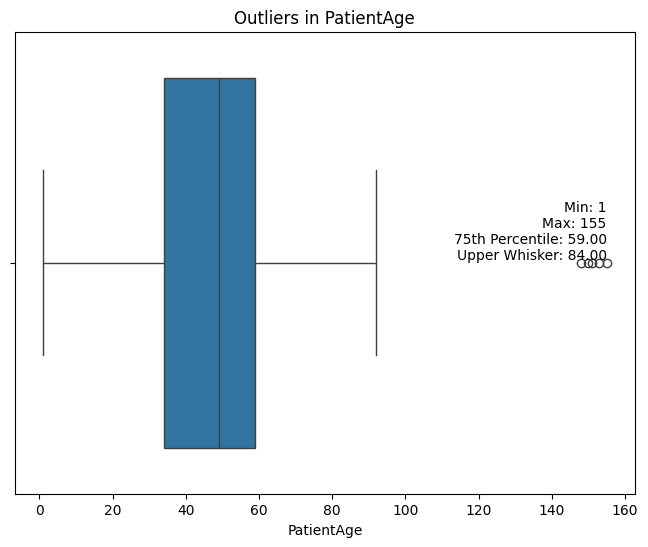

In [ ]:
# Checking outliers in 'PatientAge'

# Calculate key statistics for 'PatientAge'
min_age = train_dataset['PatientAge'].min()
max_age = train_dataset['PatientAge'].max()
age_75th_percentile = train_dataset['PatientAge'].quantile(0.75)
age_iqr_upper = age_75th_percentile + (age_75th_percentile - train_dataset['PatientAge'].quantile(0.25))

# Visualize the distribution and outliers in 'PatientAge' using a boxplot
fig = plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=train_dataset['PatientAge'], orient='h')
ax.set_title('Outliers in PatientAge')

# Display the calculated statistics on the plot
ax.text(
    x=max_age, y=0,
    s=f'Min: {min_age}\nMax: {max_age}\n75th Percentile: {age_75th_percentile:.2f}\nUpper Whisker: {age_iqr_upper:.2f}',
    ha='right', va='bottom', fontsize=10, color='black'
)

plt.show()

In [ ]:
# Removing outliers from 'PatientAge'

# Define the upper threshold for 'PatientAge' (e.g., 100)
max_age_threshold = 100

# Clip the 'PatientAge' values to remove outliers above the defined threshold
train_dataset['PatientAge'] = train_dataset['PatientAge'].clip(lower=train_dataset['PatientAge'].min(), upper=max_age_threshold)

# Calculate and display the updated descriptive statistics for 'PatientAge'
summary_stats = train_dataset['PatientAge'].describe().astype(int)
summary_stats


count     30227
unique       93
top          58
freq        955
Name: PatientAge, dtype: int64

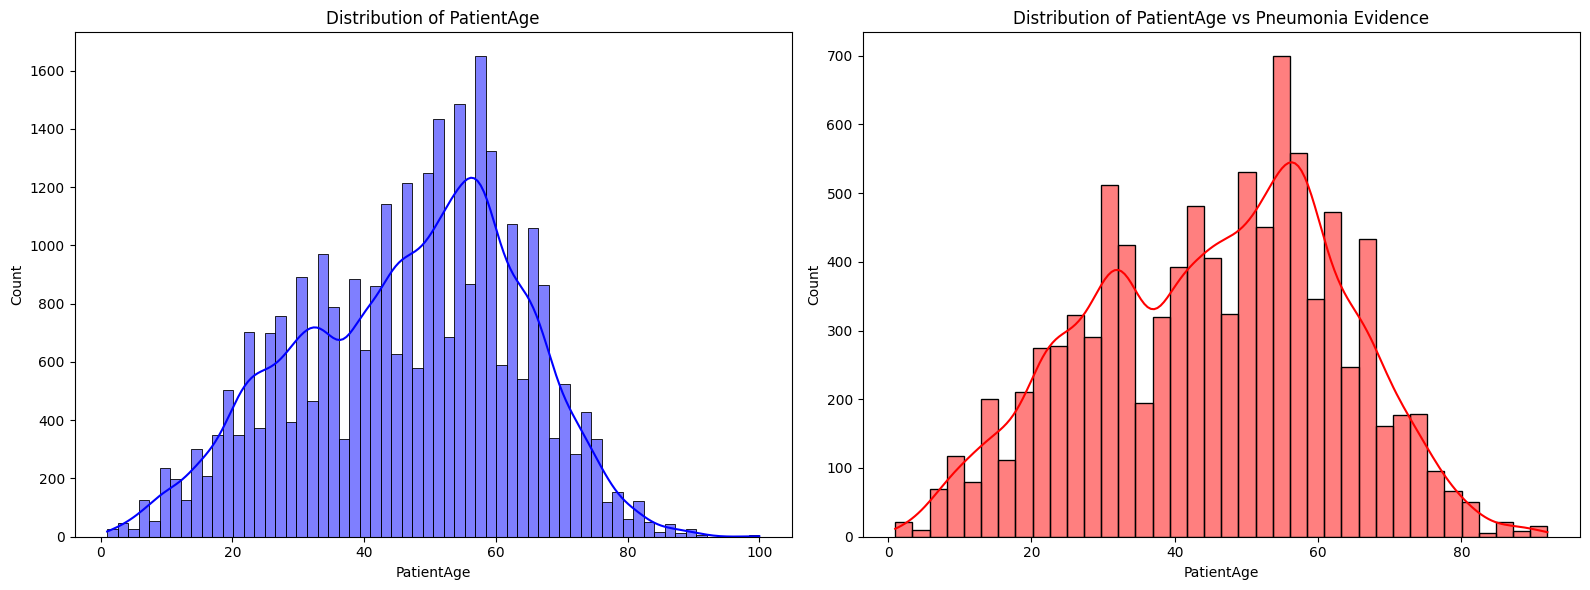

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot distribution of 'PatientAge' for the entire dataset
sns.histplot(train_dataset['PatientAge'], kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribution of PatientAge')

# Plot distribution of 'PatientAge' for cases with Target = 1 (pneumonia evidence)
sns.histplot(train_dataset.loc[train_dataset['Target'] == 1, 'PatientAge'], kde=True, ax=axes[1], color='red')
axes[1].set_title('Distribution of PatientAge vs Pneumonia Evidence')

# Display the plot
plt.tight_layout()
plt.show()

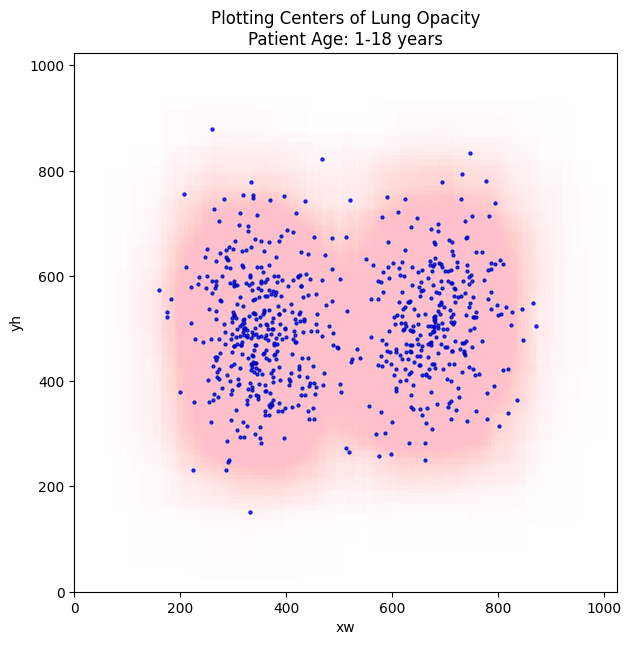

In [ ]:
# Create age-based data subsets
age_groups = {
    '18 and under': bboxes[bboxes['PatientAge'] < 19],
    '19-30': bboxes[(bboxes['PatientAge'] >= 19) & (bboxes['PatientAge'] < 31)],
    '31-50': bboxes[(bboxes['PatientAge'] >= 31) & (bboxes['PatientAge'] < 51)],
    '51-70': bboxes[(bboxes['PatientAge'] >= 51) & (bboxes['PatientAge'] < 71)],
    '71-90': bboxes[(bboxes['PatientAge'] >= 71) & (bboxes['PatientAge'] < 100)]
}

# Scatter plot for patients aged 1-18 years
plot_bboxes_scatter(age_groups['18 and under'], 'blue', 'pink', 'Patient Age: 1-18 years')

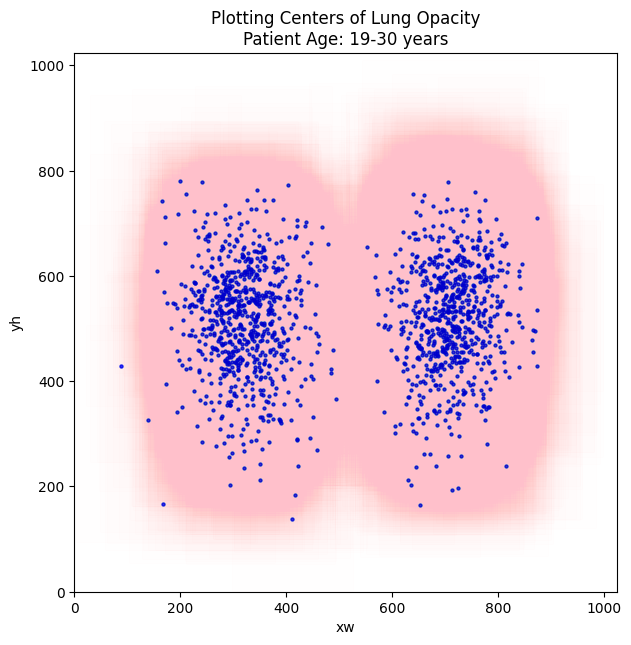

In [ ]:
plot_bboxes_scatter(age_groups['19-30'],'blue', 'pink', 'Patient Age: 19-30 years')

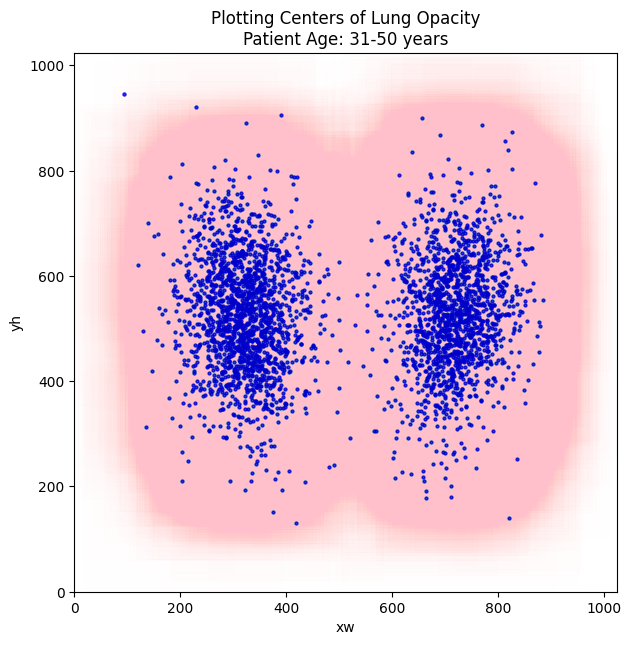

In [ ]:
plot_bboxes_scatter(age_groups['31-50'],'blue', 'pink', 'Patient Age: 31-50 years')

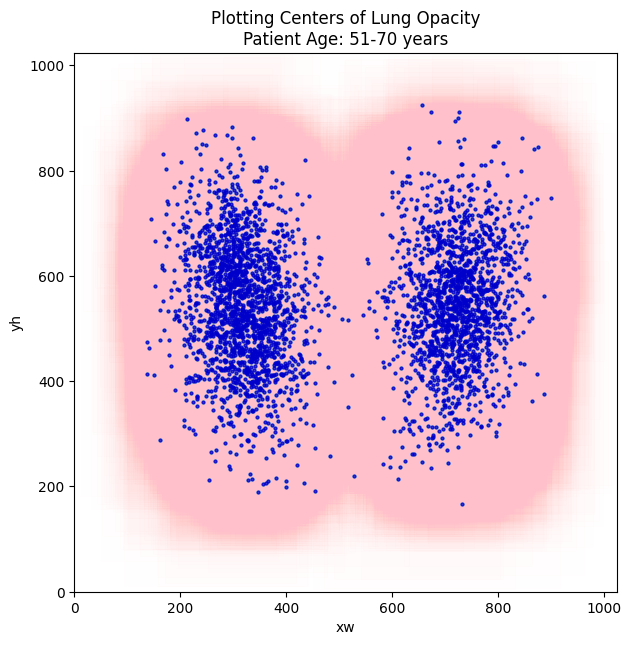

In [ ]:
plot_bboxes_scatter(age_groups['51-70'],'blue', 'pink', 'Patient Age: 51-70 years')

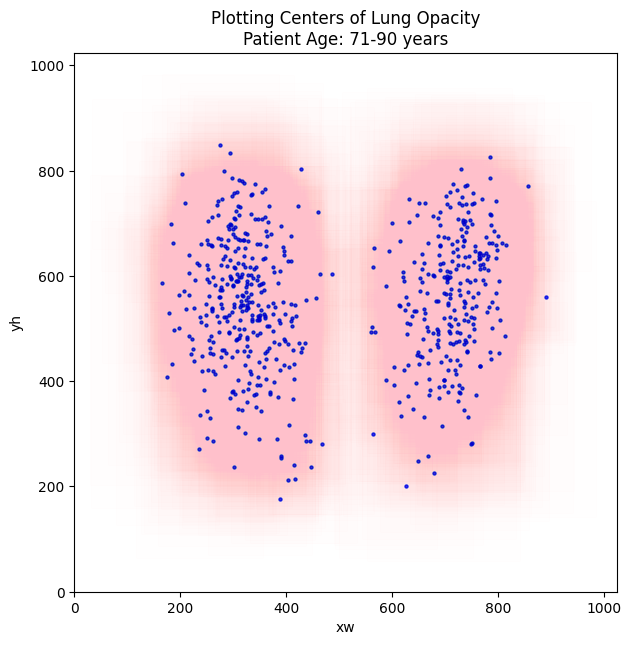

In [ ]:
plot_bboxes_scatter(age_groups['71-90'],'blue', 'pink', 'Patient Age: 71-90 years')

##### Step 5: Display images with bounding box. [ 5 points ]

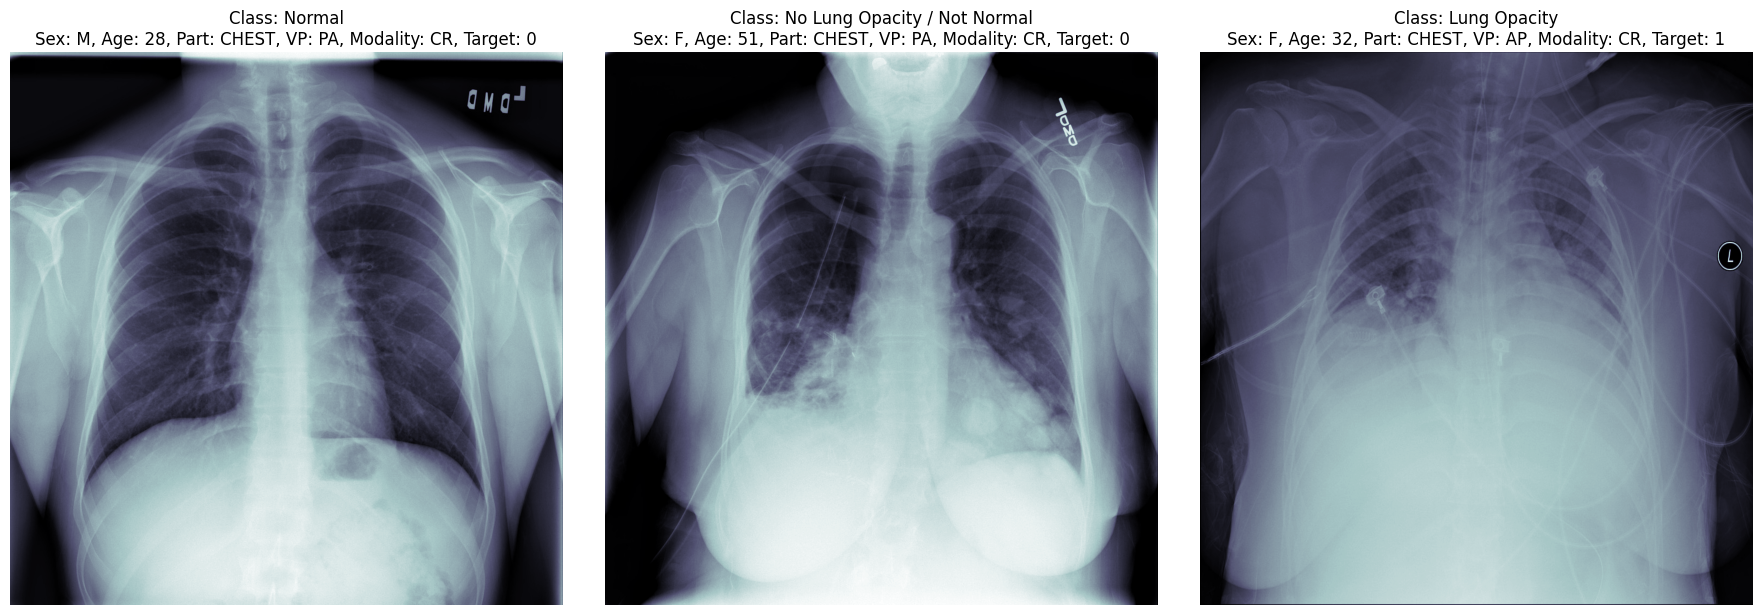

In [ ]:
# Extract samples for each class (Normal, No Lung Opacity / Not Normal, Lung Opacity)
sample_normal = train_dataset.loc[train_dataset['class'] == 'Normal'].iloc[0]
sample_no_lung_opacity = train_dataset.loc[train_dataset['class'] == 'No Lung Opacity / Not Normal'].iloc[0]
sample_lung_opacity = train_dataset.loc[train_dataset['class'] == 'Lung Opacity'].iloc[1]

# Read the corresponding DICOM files
ds_normal = dcm.dcmread(sample_normal['path'])
ds_no_lung_opacity = dcm.dcmread(sample_no_lung_opacity['path'])
ds_lung_opacity = dcm.dcmread(sample_lung_opacity['path'])

# Set up the subplot for displaying the images
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Function to display image with metadata
def display_image(ax, ds, sample, class_label):
    ax.imshow(ds.pixel_array, cmap=plt.cm.bone)
    ax.set_title(f"Class: {class_label}\n"
                 f"Sex: {sample['PatientSex']}, Age: {sample['PatientAge']}, "
                 f"Part: {sample['BodyPartExamined']}, VP: {sample['ViewPosition']}, "
                 f"Modality: {sample['Modality']}, Target: {sample['Target']}")
    ax.axis('off')

# Display the images for each class
display_image(axes[0], ds_normal, sample_normal, 'Normal')
display_image(axes[1], ds_no_lung_opacity, sample_no_lung_opacity, 'No Lung Opacity / Not Normal')
display_image(axes[2], ds_lung_opacity, sample_lung_opacity, 'Lung Opacity')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


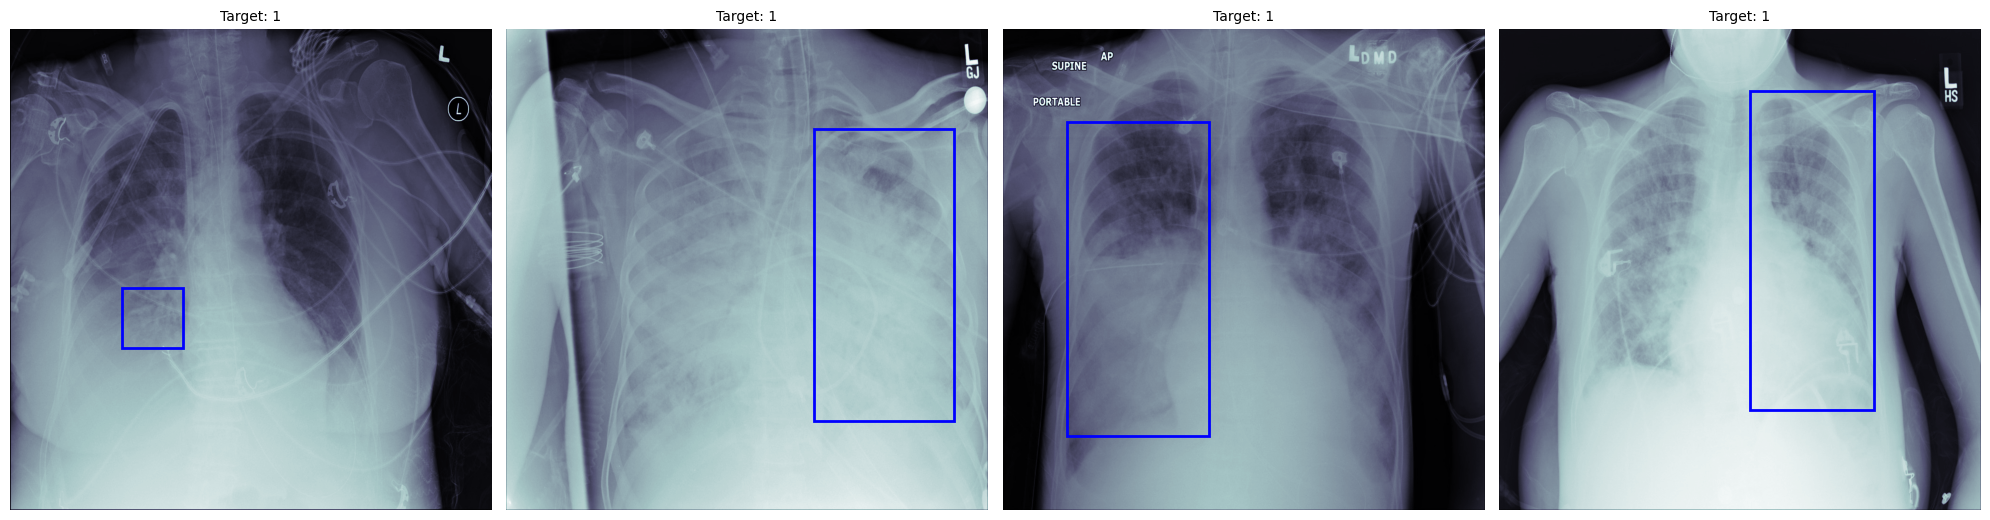

In [ ]:
# Function to display random DICOM images with bounding boxes
def show_dicom_images_with_bboxes(data, img_path, num_images=4):
    # Filter for images with bounding boxes (Target == 1)
    bbox_images = data[data['Target'] == 1]

    # Randomly sample images
    sampled_images = bbox_images.sample(num_images, random_state=42)

    # Initialize subplot for displaying images
    fig, axes = plt.subplots(1, num_images, figsize=(20, 10))

    # Loop through sampled images and display each one with bounding box
    for ax, (_, row) in zip(axes, sampled_images.iterrows()):
        # Construct the full path to the DICOM image
        dicom_path = f"{img_path}/{row['path'].split('/')[-1]}"

        # Read the DICOM image
        ds = dcm.dcmread(dicom_path)
        image = ds.pixel_array

        # Display the DICOM image in grayscale using bone colormap
        ax.imshow(image, cmap=plt.cm.bone)
        ax.set_title(f"Target: {row['Target']}", fontsize=10)

        # Extract bounding box coordinates and dimensions
        x, y, width, height = row['x'], row['y'], row['width'], row['height']

        # Create and overlay the bounding box on the image
        rect = Rectangle((x, y), width, height, linewidth=2, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)

        # Hide the axis for cleaner visualization
        ax.axis('off')

    # Adjust layout for better spacing and show the plot
    plt.tight_layout()
    plt.show()

# Example usage: Display 4 random images with bounding boxes
show_dicom_images_with_bboxes(train_dataset, img_path='/content/drive/MyDrive/Dataset/stage_2_train_images')


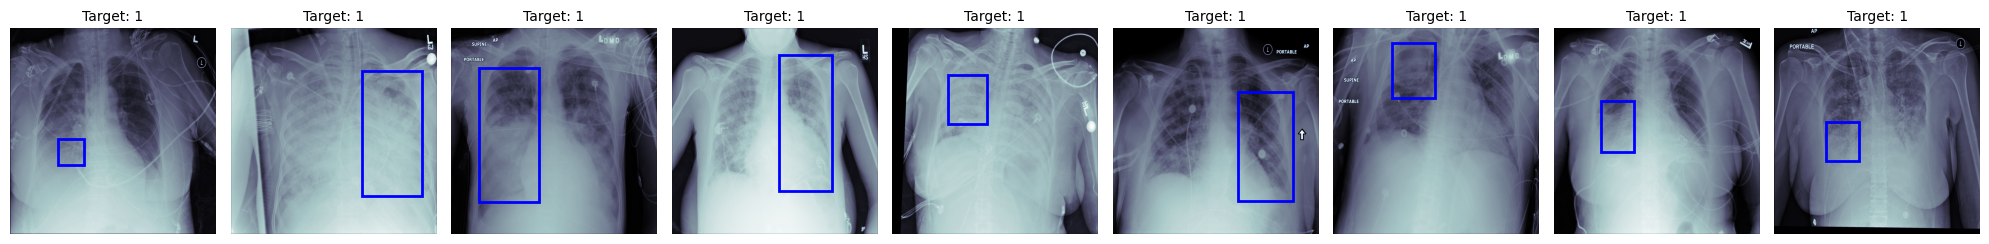

In [ ]:
show_dicom_images_with_bboxes(
    data=train_dataset.loc[train_dataset['Target'] == 1],  # Filter data for Target == 1
    img_path='/content/drive/MyDrive/Dataset/stage_2_train_images/',
    num_images=9
)

#### Conclusion:

* The training dataset, comprising CSV files and the corresponding training image folder, includes data for 26,684 unique patients. Some patients have multiple entries across both CSV files. The majority of the patients fall under Target = 0, indicating no evidence of pneumonia.

* A subset of patients has multiple bounding boxes, with a maximum of four. The "No Lung Opacity / Not Normal" and "Normal" classes are associated with Target = 0, while "Lung Opacity" is linked to Target = 1.

* The images are in DICOM format, from which key patient details such as age, sex, and view position are extracted. Two imaging techniques are used: Anteroposterior (AP) and Posteroanterior (PA). Patient ages range from 1 to 155 years, but for analysis purposes, ages were capped at 100.

* The centers of the bounding boxes are distributed throughout the lung area, although some of these centers are considered outliers.

Step 6: Design, train and test basic CNN models for classification. [ 10 points ]

#### Design, train and test basic CNN models for classification

In [ ]:
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import os
import pydicom as dcm

# Load CSV files for class information and train labels
train_class = pd.read_csv('/content/drive/MyDrive/Dataset/stage_2_detailed_class_info.csv')
train_labels = pd.read_csv('/content/drive/MyDrive/Dataset/stage_2_train_labels.csv')

# Define paths for train and test image directories
train_path = Path('/content/drive/MyDrive/Dataset/stage_2_train_images')
test_path = Path('/content/drive/MyDrive/Dataset/stage_2_test_images')

# Merge train labels with class information
train_meta = pd.concat([train_labels, train_class.drop(columns=['patientId'])], axis=1)

# Create a DataFrame with count of bounding boxes per patient
box_df = train_meta.groupby('patientId').size().reset_index(name='boxes')

# Merge box count into the train metadata
train_ds = pd.merge(train_meta, box_df, on='patientId')

# Count how many patients fall into each bounding box category
box_df = box_df.groupby('boxes').size().reset_index(name='patients')

# List of columns to store DICOM metadata
vars_to_extract = ['PatientAge', 'PatientSex', 'ImagePath']

def process_dicom_data(df, image_path):
    """
    Process DICOM images to extract metadata and add it to the DataFrame.

    Parameters:
    - df: DataFrame with patient information.
    - image_path: Path to the directory containing DICOM images.
    """
    # Add columns to the DataFrame to store extracted DICOM metadata
    for var in vars_to_extract:
        df[var] = None

    # Get list of DICOM image filenames in the directory
    images = os.listdir(image_path)

    # Loop through each image and extract relevant information
    for img_name in tqdm(images, desc="Processing DICOM files"):
        image_file = os.path.join(image_path, img_name)

        try:
            # Read the DICOM file
            img_data = dcm.dcmread(image_file, force=True)

            # Find the corresponding row in the DataFrame based on patient ID
            idx = (df['patientId'] == img_data.PatientID)

            # Extract and assign metadata to the DataFrame
            df.loc[idx, 'PatientAge'] = pd.to_numeric(img_data.PatientAge, errors='coerce')
            df.loc[idx, 'PatientSex'] = img_data.PatientSex
            df.loc[idx, 'ImagePath'] = image_file

        except Exception as e:
            print(f"Error processing file {img_name}: {e}")

# Process DICOM data for training dataset
process_dicom_data(train_ds, '/content/drive/MyDrive/Dataset/stage_2_train_images')


Processing DICOM files: 100%|██████████| 26684/26684 [09:14<00:00, 48.09it/s] 


In [ ]:
train_ds.to_csv('pneumonia_ds', index=False)

In [ ]:
# Initialize empty lists for images and labels
image_list = []
class_labels = []

# Define the target image size
ADJUSTED_IMAGE_SIZE = 128

def read_and_reshape_image(image):
    """
    Reads the image, converts it to a numpy array, and resizes it to the target size.
    """
    img = np.array(image).astype(np.uint8)
    resized_img = cv2.resize(img, (ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)
    return resized_img

def populate_images_and_labels(row_data):
    """
    Iterates through each row in the provided metadata, loads the corresponding DICOM images,
    converts them to 3-channel format, resizes them, and stores them in the image list with
    their corresponding class labels.
    """
    for _, row in row_data.iterrows():
        patient_id = row.patientId
        class_label = row["class"]

        # Construct DICOM file path
        dcm_file_path = f'/content/drive/MyDrive/Dataset/stage_2_train_images/{patient_id}.dcm'
        dcm_data = dcm.dcmread(dcm_file_path)
        img = dcm_data.pixel_array

        # Ensure the image has 3 channels (convert grayscale to RGB if necessary)
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, axis=-1)

        # Resize and append the image to the image list
        image_list.append(read_and_reshape_image(img))
        # Append the class label to the label list
        class_labels.append(class_label)

    # Convert lists to numpy arrays before returning
    return np.array(image_list), np.array(class_labels)

# Populate images and labels using metadata
images, labels = populate_images_and_labels(train_meta)

# Print the shapes of the resulting arrays
print(images.shape, labels.shape)


(30227, 128, 128, 3) (30227,)


In [ ]:
# Initialize the LabelBinarizer and encode the labels
label_binarizer = LabelBinarizer()
y_encoded = label_binarizer.fit_transform(labels)

# Split the data into training, testing, and validation sets
from sklearn.model_selection import train_test_split

# First, split the data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(images, y_encoded, test_size=0.3, random_state=50)

# Then, split the test set into validation (50%) and remaining test data (50%)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=50)


In [ ]:
def create_cnn_model(input_height, input_width, input_channels, num_classes):
    """
    Builds and compiles a Convolutional Neural Network model.

    Args:
    input_height (int): Height of the input image.
    input_width (int): Width of the input image.
    input_channels (int): Number of color channels in the input image (e.g., 3 for RGB).
    num_classes (int): Number of output classes for classification.

    Returns:
    model: A compiled CNN model.
    """
    model = Sequential()

    # First Convolutional Layer + MaxPooling + BatchNormalization
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(input_height, input_width, input_channels)))
    model.add(BatchNormalization())  # Adding batch normalization to stabilize training
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Layer + MaxPooling + BatchNormalization
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization()) # Adding batch normalization to stabilize training
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Layer + MaxPooling + BatchNormalization
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization()) # Adding batch normalization to stabilize training
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output from the convolutional layers
    model.add(Flatten())

    # First Fully Connected Layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Higher dropout to prevent overfitting

    # Second Fully Connected Layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer with Softmax activation
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the CNN model
cnn = create_cnn_model(ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE, 3, 3)

# Print the model architecture summary
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,782,147 (10.61 MB)

 Trainable params: 2,781,699 (10.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
history = cnn.fit(X_train,
                  y_train,
                  epochs = 20,
                  validation_data = (X_val,y_val),
                  batch_size = 16)

Epoch 1/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.4544 - loss: 1.2634 - val_accuracy: 0.4778 - val_loss: 0.9677
Epoch 2/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5756 - loss: 0.8736 - val_accuracy: 0.5696 - val_loss: 0.8908
Epoch 3/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6123 - loss: 0.8162 - val_accuracy: 0.4688 - val_loss: 1.2196
Epoch 4/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6338 - loss: 0.7810 - val_accuracy: 0.6315 - val_loss: 0.8007
Epoch 5/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.6554 - loss: 0.7494 - val_accuracy: 0.5528 - val_loss: 1.1939
Epoch 6/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6596 - loss: 0.7401 - val_accuracy: 0.6507 - val_loss: 0.7639
Epoch 7/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.6722 - loss: 0.7215 - val_accuracy: 0.6642 - val_loss: 0.7158
Epoch 8/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.6763 -

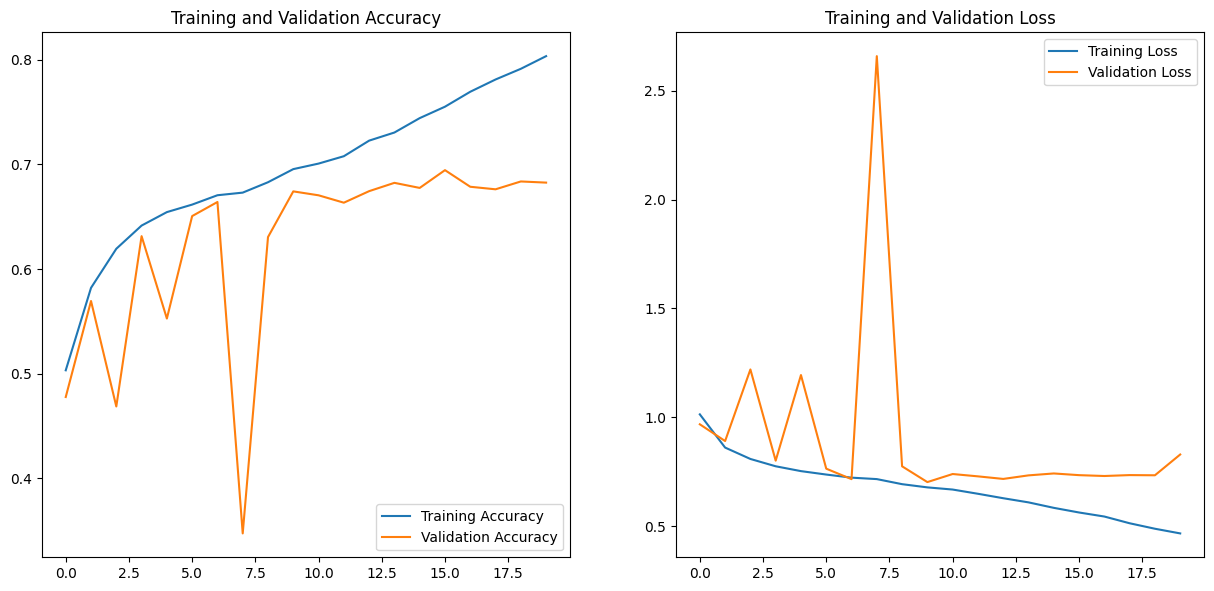

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))  # This ensures the range matches the length of your data

plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else int(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

Generating predictions on training set...
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Confusion matrix, without normalization


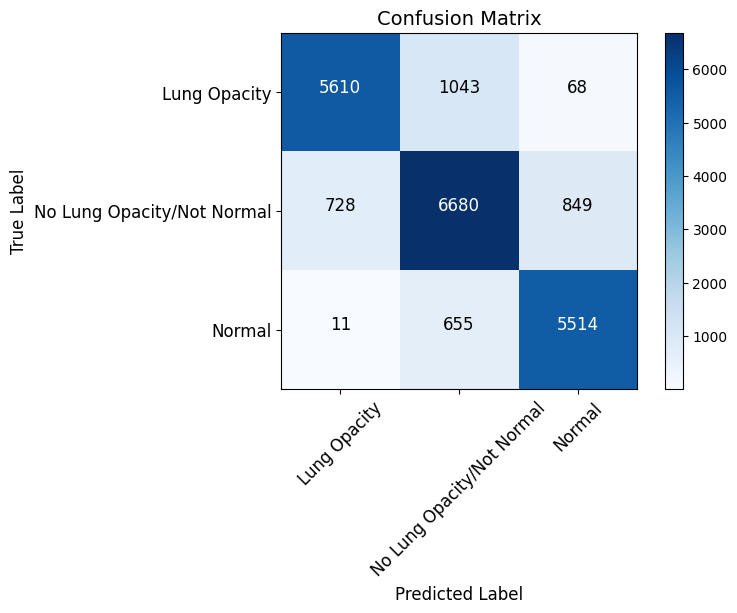


Classification Report:

                            precision    recall  f1-score   support

              Lung Opacity       0.88      0.83      0.86      6721
No Lung Opacity/Not Normal       0.80      0.81      0.80      8257
                    Normal       0.86      0.89      0.87      6180

                  accuracy                           0.84     21158
                 macro avg       0.85      0.85      0.85     21158
              weighted avg       0.84      0.84      0.84     21158



In [ ]:
# Predict the values from the test set
print("Generating predictions on training set...")
Y_pred = cnn.predict(X_train)

# Convert predictions to class indices
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_train, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Display the confusion matrix
class_names = ['Lung Opacity', 'No Lung Opacity/Not Normal', 'Normal']
plot_confusion_matrix(confusion_mtx, classes=class_names, normalize=False, title='Confusion Matrix')

# Print detailed classification report
print("\nClassification Report:\n")
print(classification_report(Y_true, Y_pred_classes, target_names=class_names))

Generating predictions on test set...
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Confusion matrix, without normalization


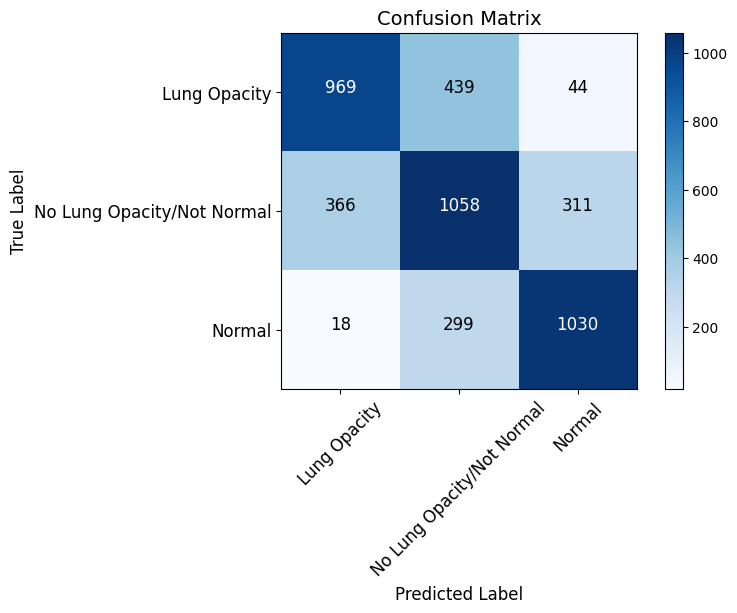


Classification Report:

                            precision    recall  f1-score   support

              Lung Opacity       0.72      0.67      0.69      1452
No Lung Opacity/Not Normal       0.59      0.61      0.60      1735
                    Normal       0.74      0.76      0.75      1347

                  accuracy                           0.67      4534
                 macro avg       0.68      0.68      0.68      4534
              weighted avg       0.68      0.67      0.67      4534



In [ ]:
# Predict the values from the test set
print("Generating predictions on test set...")
Y_pred = cnn.predict(X_test)

# Convert predictions to class indices
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Display the confusion matrix
class_names = ['Lung Opacity', 'No Lung Opacity/Not Normal', 'Normal']
plot_confusion_matrix(confusion_mtx, classes=class_names, normalize=False, title='Confusion Matrix')

# Print detailed classification report
print("\nClassification Report:\n")
print(classification_report(Y_true, Y_pred_classes, target_names=class_names))